In [136]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib

from scipy.io import wavfile

import librosa.display
import librosa.feature

import os, sys

%matplotlib inline
FIGSIZE=(18,9)

In [137]:
DATADIR = '../data/sound_files'
METAFILE = '../data/data.csv'

In [138]:
meta = pd.read_csv(METAFILE)
meta['file name'] = meta['file name'].str.replace('.raw', '', regex=False)

meta.head()

Unnamed: 0  device  hive number                 date  hive temp  \
0           0       1            5  2022-06-08 14:52:28      36.42   
1           1       1            5  2022-06-08 15:51:41      33.56   
2           2       1            5  2022-06-08 17:21:53      29.01   
3           3       1            5  2022-06-08 18:20:59      30.51   
4           4       1            5  2022-06-08 19:20:04      30.32   

   hive humidity  hive pressure  weather temp  weather humidity  \
0          30.29        1007.45         26.68                52   
1          33.98        1006.93         25.99                53   
2          42.73        1006.68         24.49                56   
3          36.74        1006.68         22.97                59   
4          35.55        1006.58         21.52                61   

   weather pressure  ...    lat    long               file name  \
0              1013  ...  37.29 -121.95  2022-06-08--14-52-28_1   
1              1012  ...  37.29 -121.95  2022-06-08--15-51-41_1   
2              1012  ...  37.29 -121.95  2022-06-08--17-21-53_1   
3              1012  ...  37.29 -121.95  2022-06-08--18-20-59_1   
4              1012  ...  37.29 -121.95  2022-06-08--19-20-04_1   

   queen presence  queen acceptance  frames  target   time  queen status  \
0               1                 2       8       0  0.583             0   
1               1                 2       8       0  0.625             0   
2               0                 0       8       1  0.708             1   
3               0                 0       8       1  0.750             1   
4               0                 0       8       1  0.792             1   

             segments  
0  [0, 1, 2, 3, 4, 5]  
1  [0, 1, 2, 3, 4, 5]  
2  [0, 1, 2, 3, 4, 5]  
3  [0, 1, 2, 3, 4, 5]  
4  [0, 1, 2, 3, 4, 5]  

[5 rows x 25 columns]

In [139]:
def _ignore():
    meta["segments"] = pd.Series(dtype='object')

    files = {}
    for it, f in meta['file name'].items():
        path = f"{DATADIR}/{f}__segment%d.wav"

        segments = []
        # Try all segments, see if they exist and add to data
        for i in range(0, 6):
            if os.path.exists(path % i):
                segments.append(i)

        meta["segments"].iloc[it] = segments

In [140]:
example = DATADIR+'/2022-06-08--14-52-28_1__segment1.wav'

60.0s
22050Hz


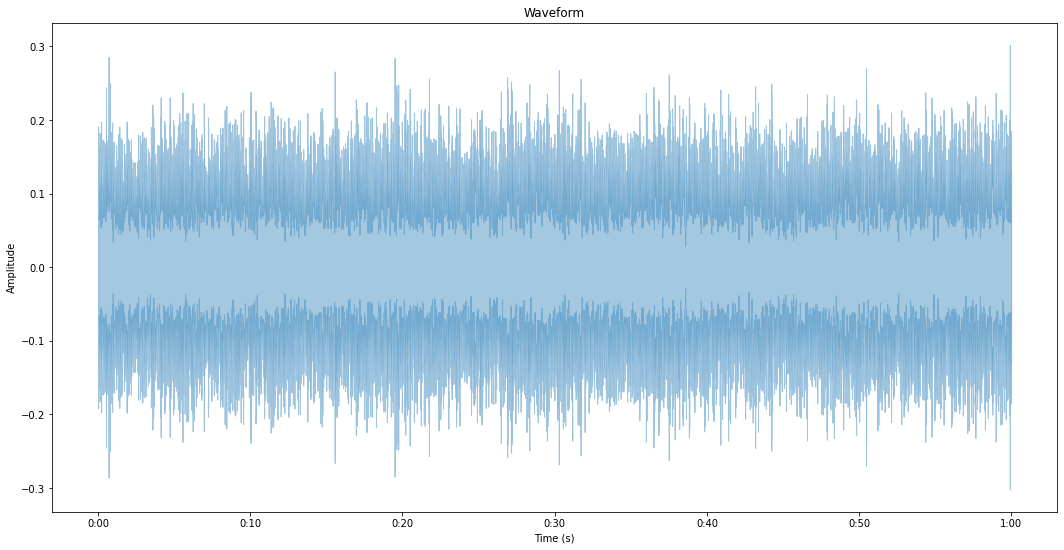

In [141]:
signal, sampleRate = librosa.load(example)

print(f"{len(signal) / sampleRate}s")
print(f"{sampleRate}Hz")

plt.figure(figsize=FIGSIZE)
librosa.display.waveshow(signal, sr=sampleRate, alpha=0.4)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Waveform")
plt.show()

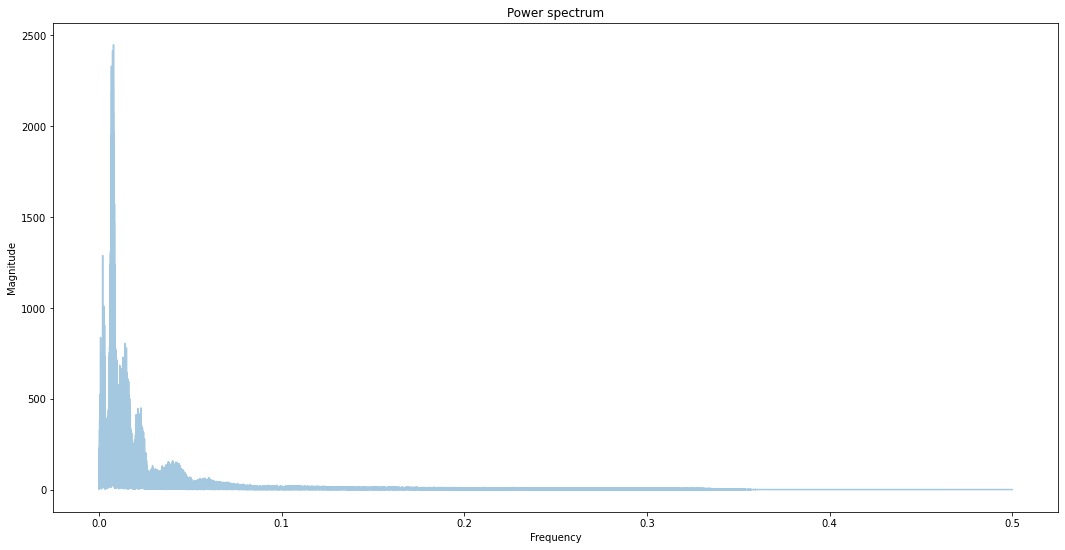

In [142]:
from scipy.fft import fft, ifft, fftfreq

# We only take the first half, since FFT is mirrored
n = len(signal)

# perform Fourier transform
yf = np.abs(fft(signal))
yf = yf[:n//2]

# create frequency variable
xf = fftfreq(n)[:n//2]

# plot spectrum
plt.figure(figsize=FIGSIZE)
plt.plot(xf, yf, alpha=0.4)
plt.xlabel("Frequency")
plt.ylabel("Magnitude")
plt.title("Power spectrum")
plt.show()

STFT hop length duration: 0.005804988662131519s
STFT window  duration:    0.023219954648526078s


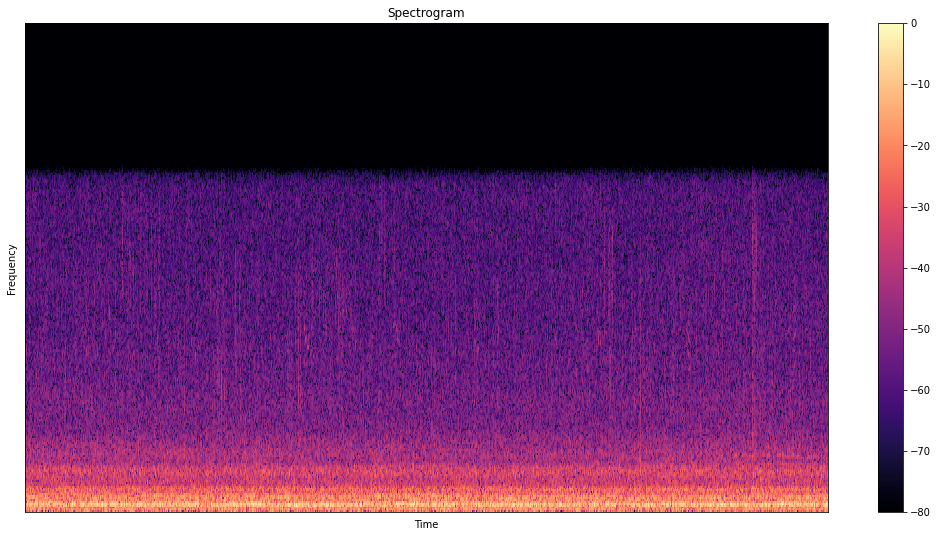

In [143]:
# STFT -> spectrogram

# hop_length -> in num. of samples
# n_fft -> window in num. of samples
# https://librosa.org/doc/main/generated/librosa.stft.html

NFFT = 512
HOPLENGTH = NFFT//4 # Usually just //4 of n_fft


print(f"STFT hop length duration: {HOPLENGTH/sampleRate}s")
print(f"STFT window  duration:    {NFFT/sampleRate}s")

# STFT
stft = librosa.stft(signal, n_fft=NFFT, hop_length=HOPLENGTH)
spec = librosa.amplitude_to_db(np.abs(stft), ref=np.max)

# Display spectogram
plt.figure(figsize=FIGSIZE)
librosa.display.specshow(spec, sr=sampleRate, hop_length=HOPLENGTH, n_fft=NFFT)

plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")
plt.show()

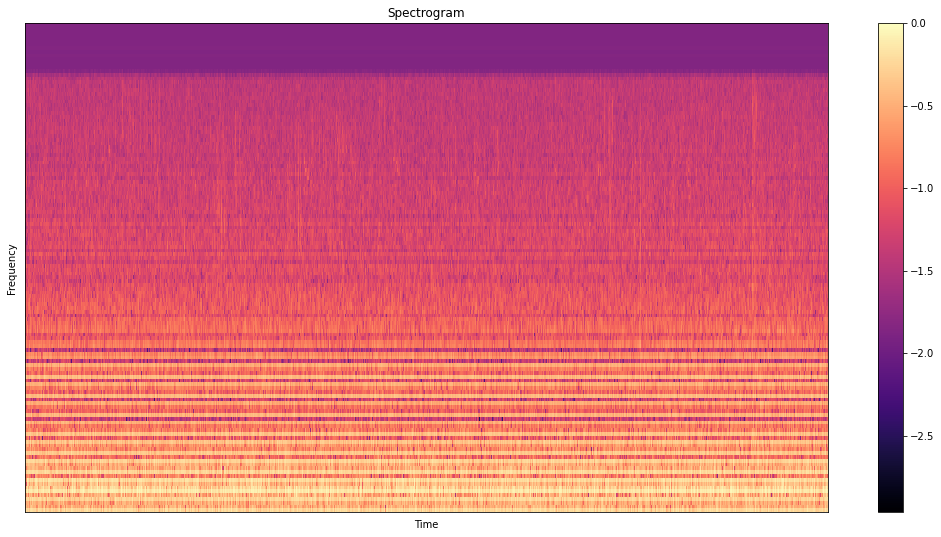

In [144]:
# Mapping to a mel spectogram
NMELS = 128

mel = librosa.feature.melspectrogram(S=spec, sr=sampleRate, n_mels=NMELS)

plt.figure(figsize=FIGSIZE)
librosa.display.specshow(mel, sr=sampleRate)

plt.xlabel("Time")
plt.ylabel("Frequency")
plt.colorbar()
plt.title("Spectrogram")
plt.show()

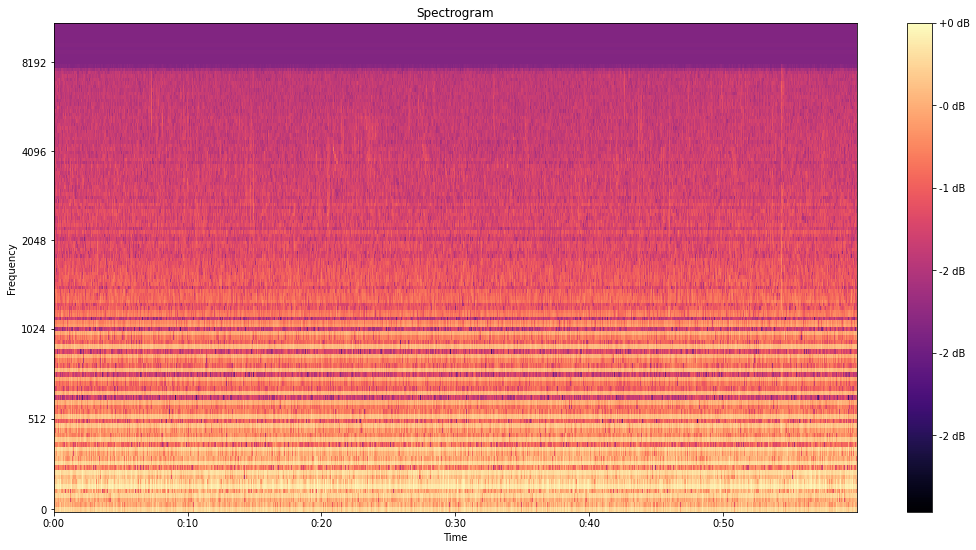

In [145]:
NFFT = 512
HOPLENGTH = NFFT//4
NMELS = 128

def spectrogram(signal, sr, n_fft=NFFT, hop_length=HOPLENGTH):
    stft = librosa.stft(signal, n_fft=n_fft, hop_length=hop_length)
    spec = librosa.amplitude_to_db(np.abs(stft), ref=np.max)
    return spec

def melspectrogram(signal, sr, n_mels=NMELS, **kwargs):
    spec = spectrogram(signal, sr, **kwargs)
    mel = librosa.feature.melspectrogram(S=spec, sr=sr, n_mels=n_mels)
    return mel
    
def f_of_file(file, f, **kwargs):
    signal, sr = librosa.load(file)
    return f(signal, sr, **kwargs), sr

def mel_of_file(file, **kwargs):
    return f_of_file(file, melspectrogram)

def display_spec(spec, sr, y_axis='mel', figsize=FIGSIZE, n_fft=NFFT, hop_length=HOPLENGTH, **kwargs):
    # Display spectogram
    plt.figure(figsize=FIGSIZE)
    librosa.display.specshow(spec, y_axis=y_axis, x_axis='time', 
                             sr=sr, n_fft=n_fft, 
                             hop_length=hop_length, **kwargs)

    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar(format="%+2.f dB")
    plt.title("Spectrogram")
    plt.show()

display_spec(*mel_of_file(example))

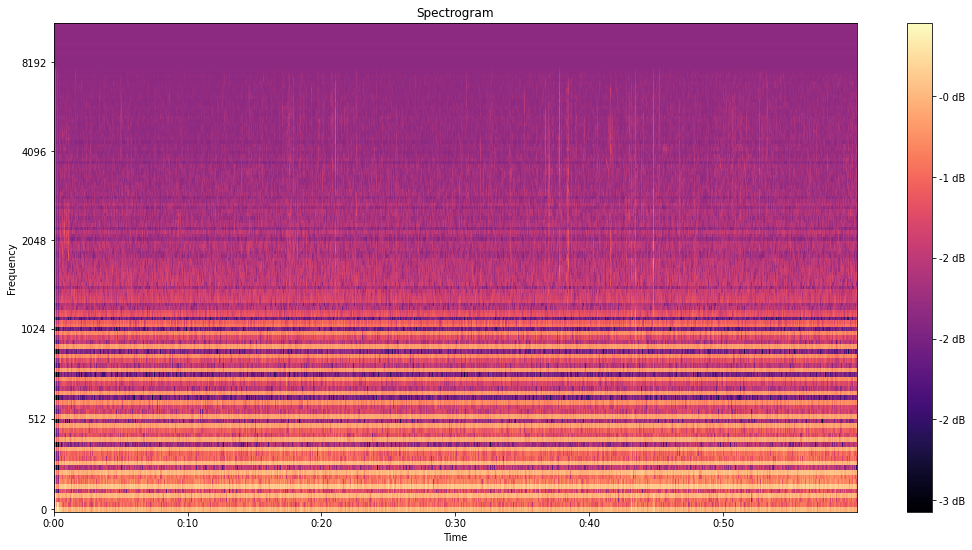

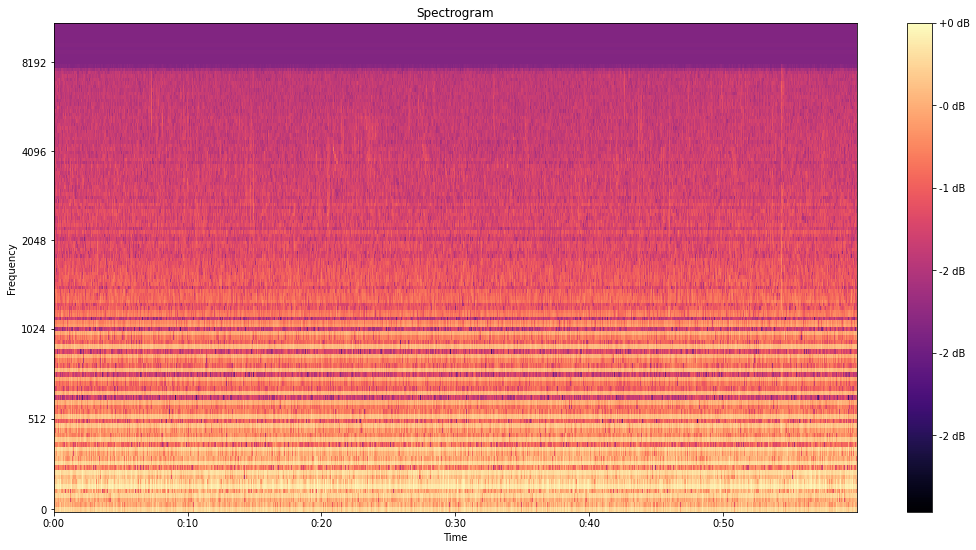

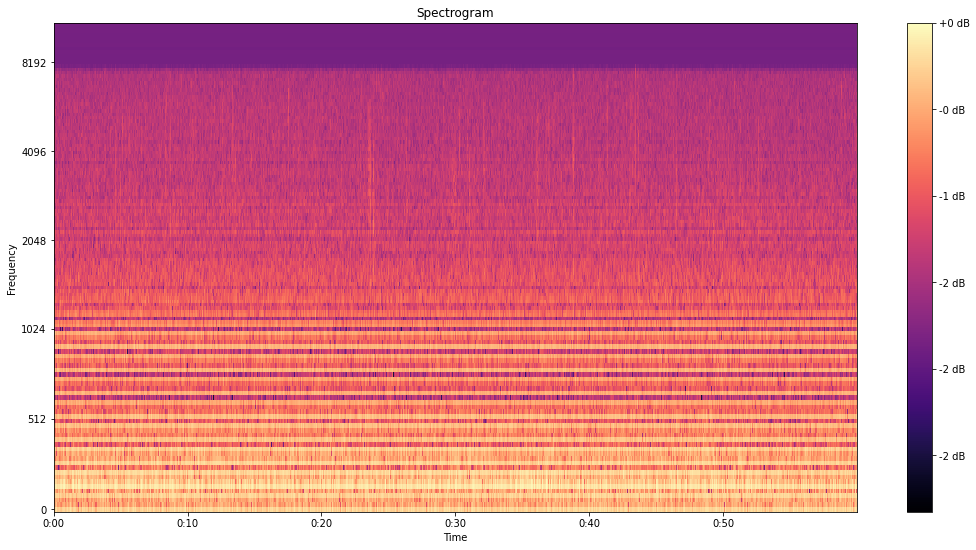

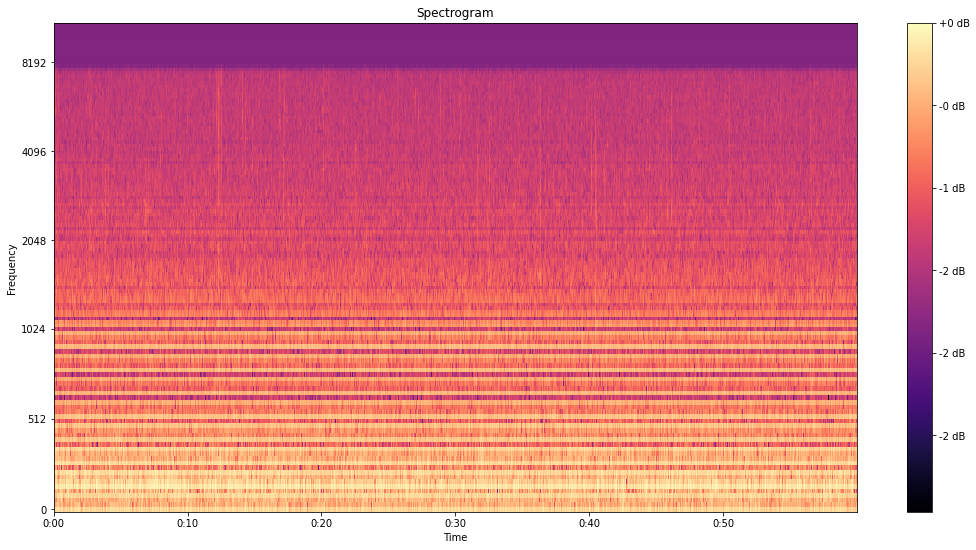

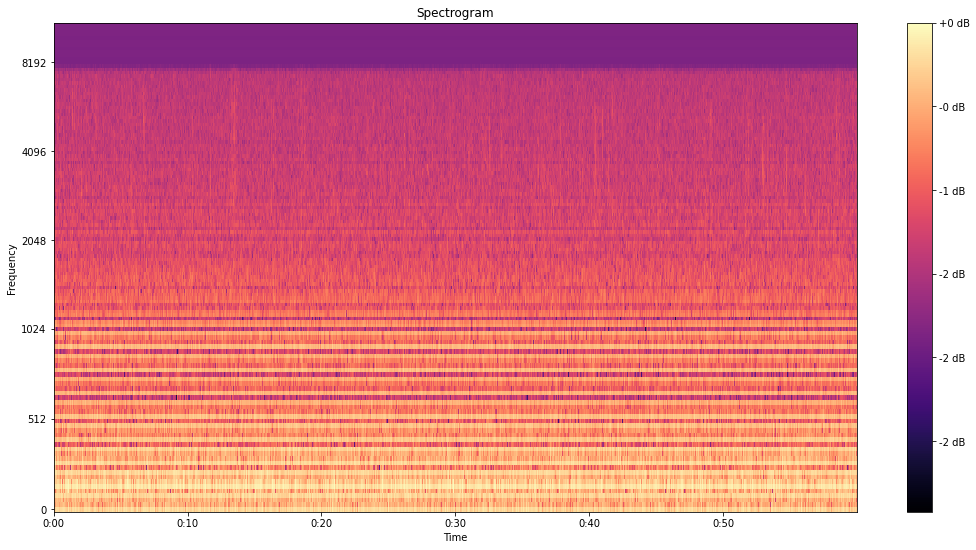

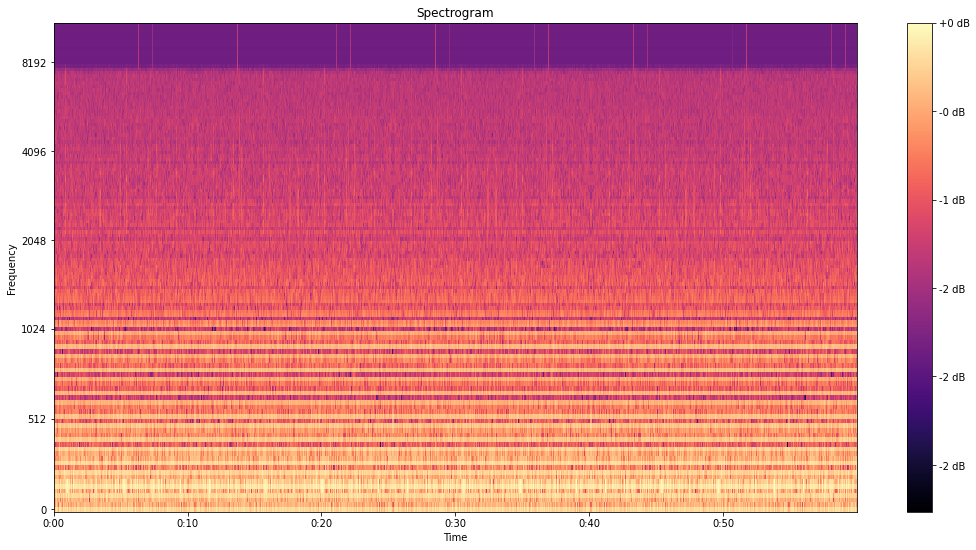

In [146]:
tmp = DATADIR+'/2022-06-08--14-52-28_1__segment%d.wav'

examples = []
for i in range(6):
    m, sr = mel_of_file(tmp % i)
    display_spec(m, sr)

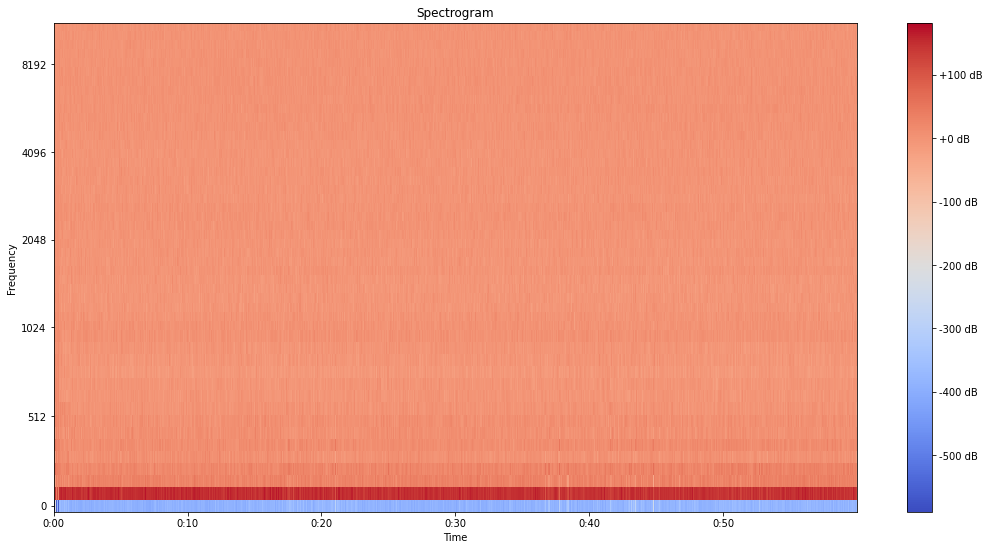

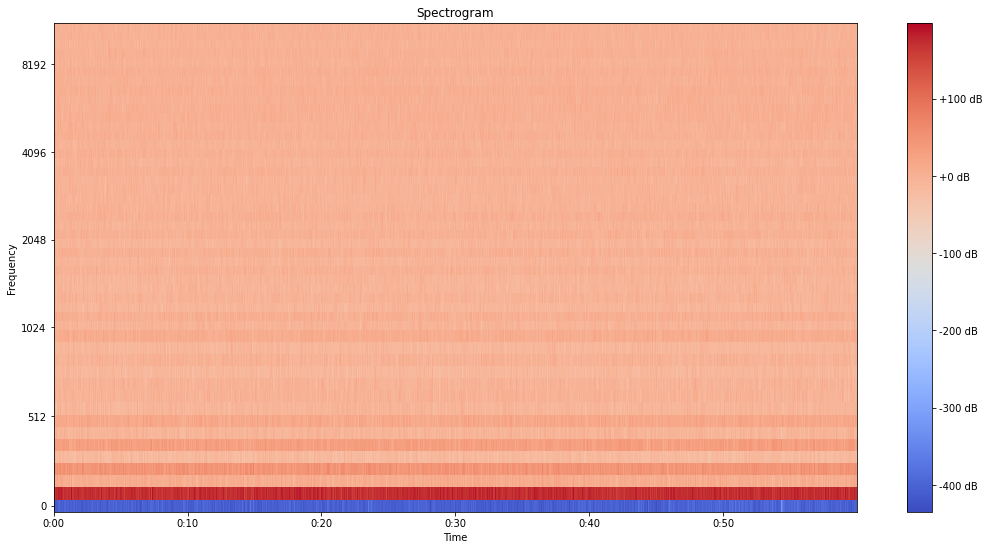

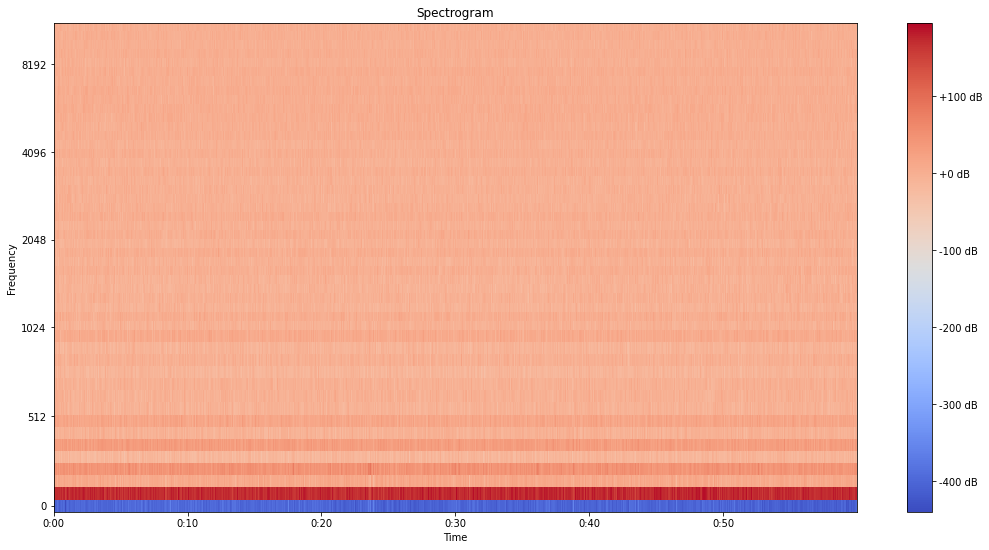

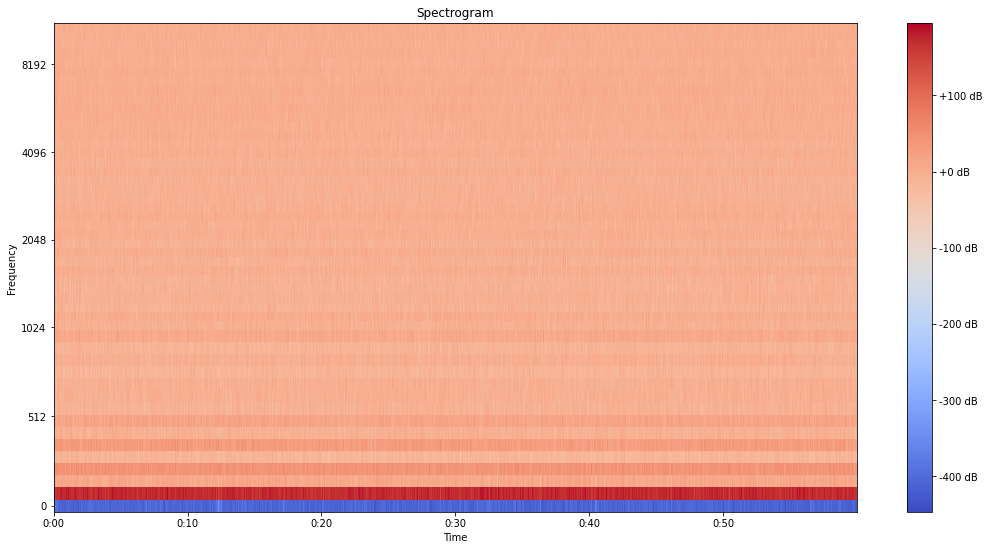

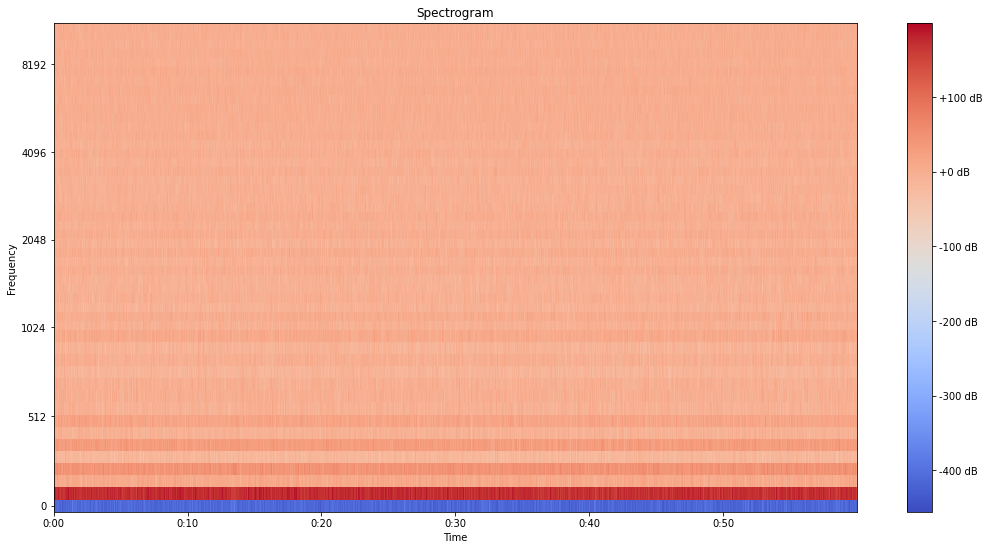

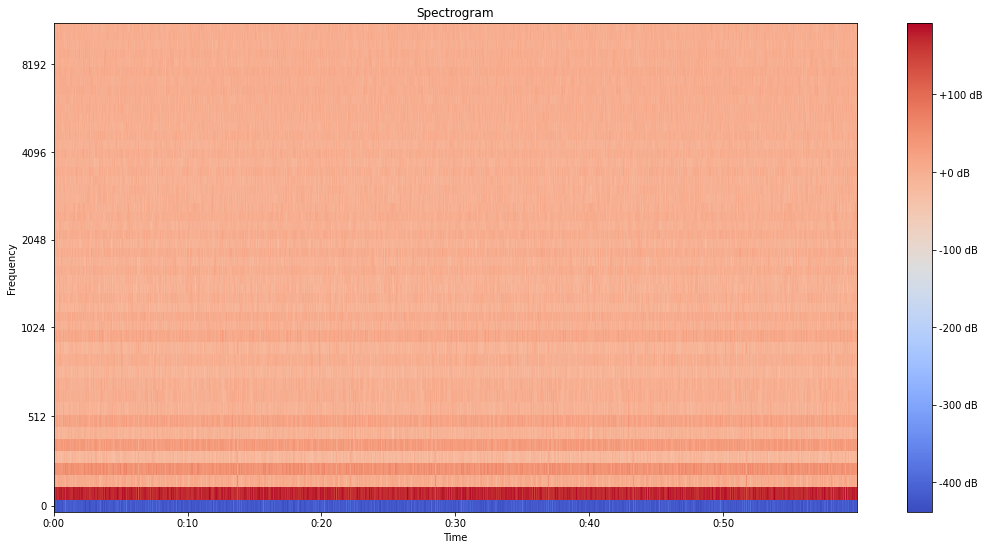

In [147]:

NMFCC = 49
for i in range(6):
    signal, sr = librosa.load(tmp % i)
    spec = spectrogram(signal, sr)
    mfccs = librosa.feature.mfcc(y=signal, sr=sr, n_fft=NFFT, hop_length=HOPLENGTH, n_mfcc=NMFCC)
    display_spec(mfccs, sr)

In [148]:
meta[meta["queen presence"] != 0].iloc[0], meta[meta["queen presence"] != 1].iloc[0]

(Unnamed: 0                               0
 device                                   1
 hive number                              5
 date                   2022-06-08 14:52:28
 hive temp                            36.42
 hive humidity                        30.29
 hive pressure                      1007.45
 weather temp                         26.68
 weather humidity                        52
 weather pressure                      1013
 wind speed                            8.75
 gust speed                             NaN
 weatherID                              711
 cloud coverage                          75
 rain                                     0
 lat                                  37.29
 long                               -121.95
 file name           2022-06-08--14-52-28_1
 queen presence                           1
 queen acceptance                         2
 frames                                   8
 target                                   0
 time                           

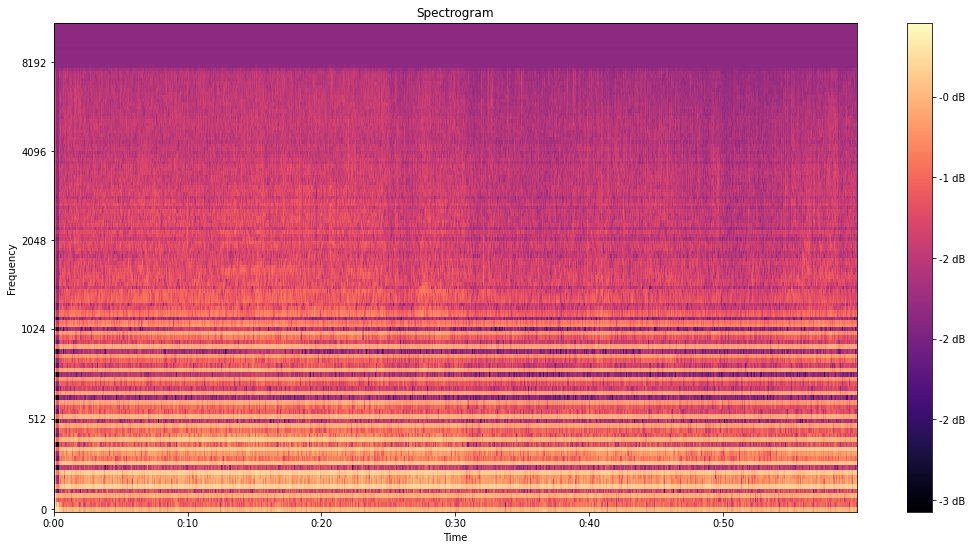

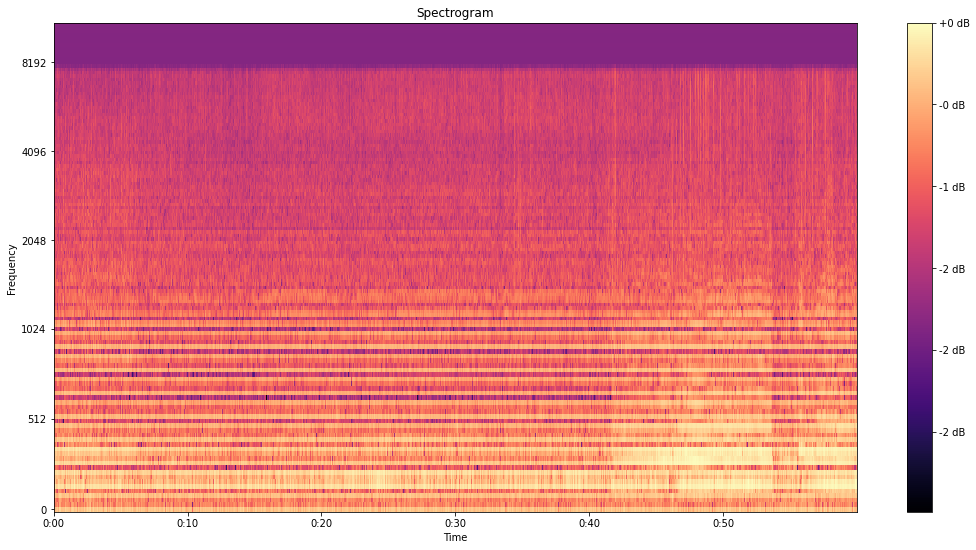

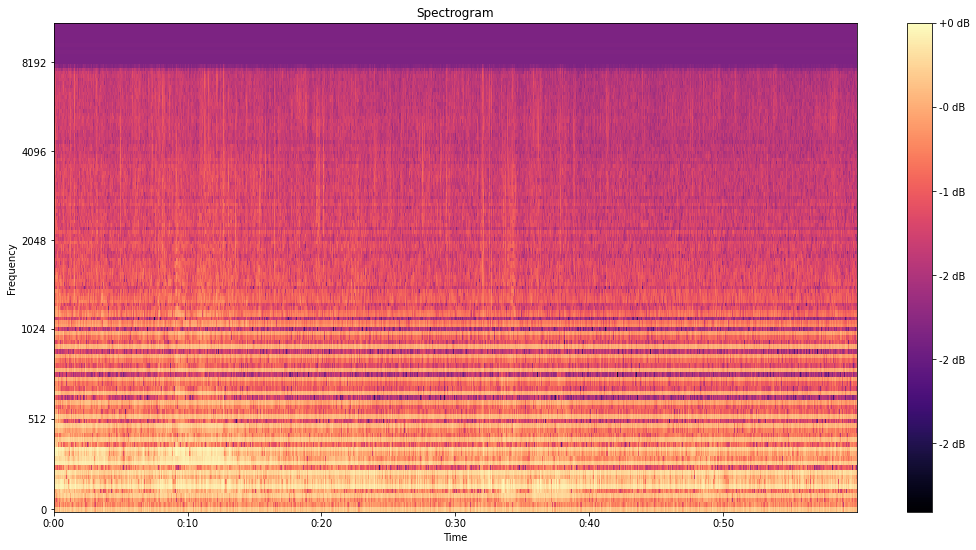

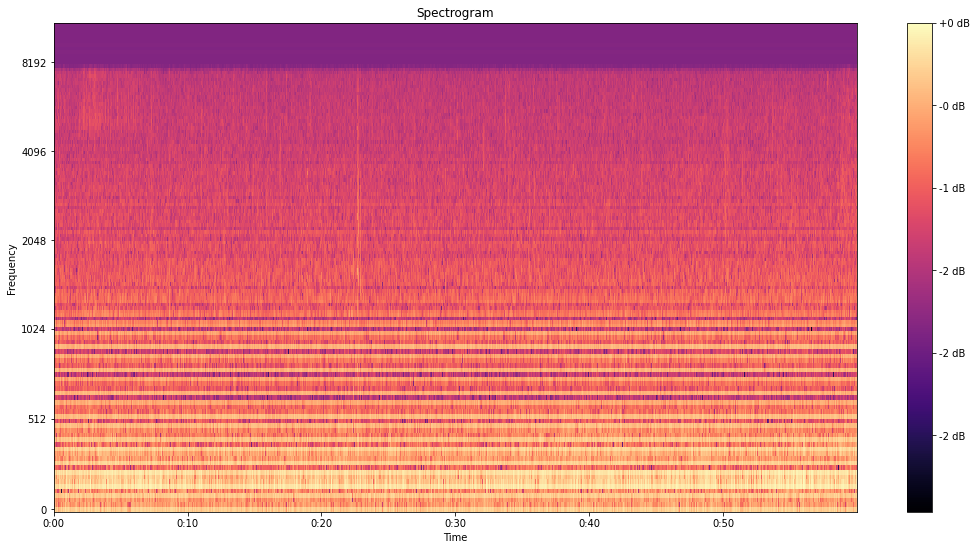

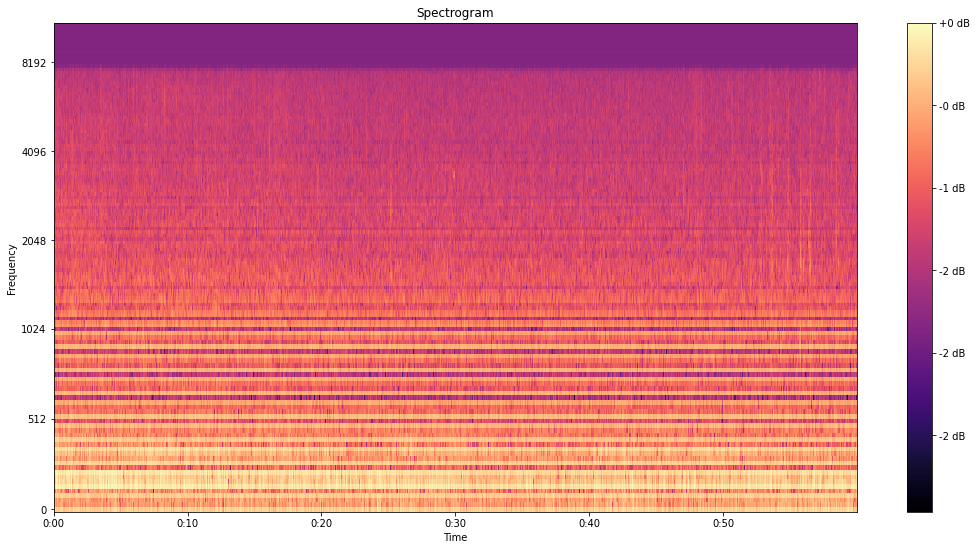

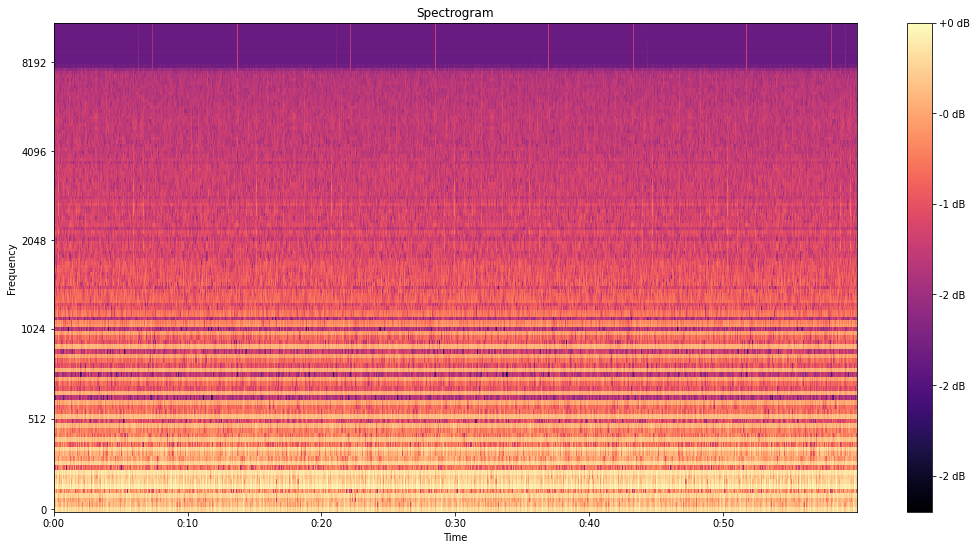

In [149]:
tmp = DATADIR+'/2022-06-08--17-21-53_1__segment%d.wav'

examples = []
for i in range(6):
    m, sr = mel_of_file(tmp % i)
    display_spec(m, sr)

# Saving the Mel Spectrograms

In [150]:
import ast
meta["segments"] = meta["segments"].apply(ast.literal_eval)

In [ ]:
import pylab
import tqdm

IMAGEDIR = '../data/image_files'

def dump_mel(mel, sr, f, **kwargs):
    fig = plt.figure(frameon=False)
    fig.set_size_inches(10,10)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    
    im = librosa.display.specshow(mel, y_axis='mel', x_axis='time', 
                                  sr=sr, n_fft=NFFT, 
                                  hop_length=HOPLENGTH, ax=ax,
                                  **kwargs)
    fig.savefig(f, dpi=160)
    plt.close()

for indx,value in tqdm.tqdm(meta[["file name", "segments"]].iterrows()):
    f, segments = value.to_numpy()
    for s in segments:
        wav = f"{DATADIR}/{f}__segment{s}.wav"
        img = f"{IMAGEDIR}/{f}__segment{s}.png"
        mel, sr = mel_of_file(wav)
        dump_mel(mel, sr, f=img)

17it [01:39,  6.40s/it]